## Unsupervised Learning using Approximated Density Ratios

We can estimate any distribution directly by using approximated density ratios. The idea is simple.
To estimate the density ratio $f(x) / g(x)$ we can train a classifier $s(x)$ to discriminate between $f(x)$ and $g(x)$, then we can replace $f(x)/g(x) = f(s(x))/g(s(x))$.
Thus, having data $x \sim g(x)$ we can recover the distribution $f(x)$ by modifying the data in order to maximize the estimated log ratio $log(f(s(x))) - log(g(s(x)))$.
Now, if we use an uniform distribution as $g(x) = U(x)$ we can estimate any $f(x)$ by:
 - Having data from $x_f \sim f(x)$ we generate data from a uniform distribution $x_g \sim U(x)$
 - Train a classifier to classify between $x_f$ and $x_g$.
 - Compute the log ratios $r(x) = log[f(s(x))/g(s(x))]$.
 - In order to generate data we need to modify the data generated from an uniform distribution trying to minimize the negative log ratio of the data. This can be done by gradient descent.
 - The gradient of the negative log ratio can be estimated using the chain rule as: 
 $$ \frac{d r}{d x} = \frac{d s} {dx}\cdot\bigg(\frac{1}{g(x)}\cdot\frac{d p_{x\sim g(x)}(s(x))}{d s} - \frac{1}{f(x)}\cdot\frac{d p_{x\sim f(x)}(s(x))}{d s}\bigg)$$
 - Here $\frac{d s} {dx}$ is the gradient of the classifier respect to the input which can be obtained by backpropagation.
 - $\frac{d p_{x\sim g(x)}(s(x))}{d s}$ is the derivative of the score distribution respect to the score value. This can be easily estimated since the distribution is just an univariate function.
 
This can be considered as an alternative to unsupervised learning methods such as GANs, RBM, DBN, autoencoders that try to estimate directly the distribution $f(x)$.

We now show initial results on how to sample MNIST digits using this method.

In [1]:
import ROOT
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy import ndimage

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from utils import printFrame,makePlotName
import time

import numpy as np

import os
import pdb

np.random.seed(1234)

ROOT.gROOT.SetBatch(ROOT.kTRUE)

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using Theano backend.
/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Setting some global variables (features, classifier used to approximate the ratios).

In [2]:
workspace_file = 'workspace_evaluating.root'
dir='.'
model_g='mlp'
verbose_printing=False

Read data from the MNIST dataset.

In [3]:
# read mnist data
# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# data augmentation?
#A = img.shape[0] / 3.0
#w = 2.0 / img.shape[1]
#shift = lambda x: A * np.sin(2.0*np.pi*x * w)
#for i in range(img.shape[0]):
#    img[:,i] = np.roll(img[:,i], int(shift(i)))

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print y_train

(60000, 'train samples')
(10000, 'test samples')
[5 0 4 ..., 5 6 8]


Using data from number 3 in the MNIST dataset and random values as $g(x)$.

In [4]:
# Generating datasets
X_train_1 = X_train[y_train == 3]
X_test_1 = X_test[y_test == 3]
#X_train_1 = X_train_1[np.random.choice(len(X_train_1),3000)]
#X_test_1 = X_test_1[np.random.choice(len(X_test_1),3000)]
y_train_1 = np.ones(X_train_1.shape[0])
y_test_1 = np.ones(X_test_1.shape[0])

X_train_rng = np.random.randint(256, size = (X_train_1.shape[0],X_train_1.shape[1])).astype('float32')
X_train_rng /= 255
X_test_rng = np.random.randint(256, size = (X_test_1.shape[0],X_test_1.shape[1])).astype('float32')
X_test_rng /= 255
y_train_rng = np.zeros(X_train_rng.shape[0])
y_test_rng = np.zeros(X_test_rng.shape[0])

X_train_ = np.vstack((X_train_1,X_train_rng))
y_train_ = np.append(y_train_1,y_train_rng)
X_test_ = np.vstack((X_test_1,X_test_rng))
y_test_ = np.append(y_test_1,y_test_rng)
y_train_ = np_utils.to_categorical(y_train_, 2)
y_test_ = np_utils.to_categorical(y_test_, 2)

print X_train_1.shape[0]
print X_train_rng.shape[0]


6131
6131


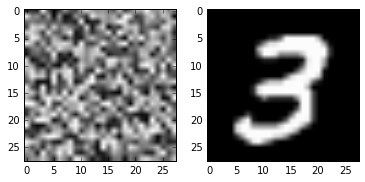

In [5]:
from matplotlib.pyplot import imshow, cm
# Plot mnist values
fig = plt.figure()
fig.add_subplot(121)

x_show = X_train_rng[10] * 255.
imshow(x_show.reshape((28,28)), cmap=cm.gray)

fig.add_subplot(122)

x_show = X_train_1[0] * 255.
imshow(x_show.reshape((28,28)), cmap=cm.gray)


Define neural network model to train on MNIST dataset.

In [6]:
# Define classifier model
batch_size = 128
nb_classes = 2
nb_epoch = 2

img_p = K.placeholder((1,784))

first_layer = Dense(512, input_shape=(784,))
first_layer.input = img_p
model = Sequential()
model.add(first_layer)
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))

rms = RMSprop()
model.compile(loss='mean_squared_error', optimizer=rms)



Functions to compute score distributions.

In [7]:
# Fuction to generate histograms
bins = 300
low = 0.
high = 1.  
c1_g=''
  
w = ROOT.RooWorkspace('w')

w.factory('score[{0},{1}]'.format(low,high))
s = w.var('score')
  
def saveHisto(w,outputs,s,bins,low,high,k='F0',j='F1', name_sufix = ''):
    
    print 'Estimating {0} {1}'.format(k,j)
    for l,name in enumerate(['sig','bkg']):
      data = ROOT.RooDataSet('{0}data_{1}_{2}{3}'.format(name,k,j,name_sufix),"data",
          ROOT.RooArgSet(s))
      hist = ROOT.TH1F('{0}hist_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',bins,low,high)
      values = outputs[l]
      #values = values[self.findOutliers(values)]
      for val in values:
        hist.Fill(val)
        s.setVal(val)
        data.add(ROOT.RooArgSet(s))
      norm = 1./hist.Integral()
      hist.Scale(norm) 
        
      s.setBins(bins)
      datahist = ROOT.RooDataHist('{0}datahist_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',
            ROOT.RooArgList(s),hist)
      histpdf = ROOT.RooHistFunc('{0}histpdf_{1}_{2}{3}'.format(name,k,j,name_sufix),'hist',
            ROOT.RooArgSet(s), datahist, 1)

      getattr(w,'import')(hist)
      getattr(w,'import')(data)
      getattr(w,'import')(datahist) # work around for morph = w.import(morph)
      getattr(w,'import')(histpdf) # work around for morph = w.import(morph)
      score_str = 'score'
      # Calculate the density of the classifier output using kernel density 
      #w.factory('KeysPdf::{0}dist_{1}_{2}({3},{0}data_{1}_{2},RooKeysPdf::NoMirror,2)'.format(name,k,j,score_str))



In [8]:
# some helper functions
def findOutliers(x):
  q5, q95 = np.percentile(x, [5,95])  
  iqr = 2.*(q95 - q5)
  outliers = (x <= q95 + iqr) & (x >= q5 - iqr)
  return outliers
def singleRatio(f0,f1):
  ratio = f1 / f0
  ratio[np.abs(ratio) == np.inf] = 0 
  ratio[np.isnan(ratio)] = 0
  return ratio

def evalDist(x,f0,val):
  iter = x.createIterator()
  v = iter.Next()
  i = 0
  while v:
    v.setVal(val[i])
    v = iter.Next()
    i = i+1
  return f0.getVal(x)

Here the loss function and the gradients are defined for the negative log ratio, a regularizer is added to the loss in order to improve local coherence of the final images.

In [9]:
# Gradient derivation and loss
# VERY raw estimation
epsilon = 1e-2
score = ROOT.RooArgSet(w.var('score'))
img_width = 28
img_height = 28
reg_alpha = .3

def evaldPdS(p_dist,s_val,epsilon):
    grad = (evalDist(score,p_dist,[s_val + epsilon]) - evalDist(score,p_dist,[s_val - epsilon])) / (2*epsilon)
    return grad
    
def continuity_loss(x):
    x_re = x.reshape((img_width,img_height))
    a = K.square(x_re[:img_width-1,:img_height-1] - x_re[1:,:img_height-1])
    b = K.square(x_re[:img_width-1,:img_height-1] - x_re[:img_width-1,1:])
    return K.sum(K.pow(a + b, 1.25))

reg_loss = K.variable(0.)
reg_loss += continuity_loss(img_p) / (img_width * img_height)
#reg_loss += K.sum(K.square(img_p)) / (img_width * img_height)

s_out = K.variable(0.)
x_out = model.get_output()

s_out += x_out[:,1][0]

grads = K.gradients(s_out, img_p)
grads_reg = K.gradients(reg_loss,img_p)

outputs = [s_out,grads]
outputs_reg = [reg_loss, grads_reg]

f_outputs = K.function([img_p], outputs)

f_outputs_reg = K.function([img_p], outputs_reg)

#F0pdf = w.function('bkghistpdf_F0_F1')
#F1pdf = w.function('sighistpdf_F0_F1')

def eval_loss_and_grads(X_val, epsilon, F1pdf = None, F0pdf = None):
    s_output,dSdX = f_outputs([X_val.reshape((1,X_test_1.shape[1]))])
    reg, reg_grad = f_outputs_reg([X_val.reshape((1,X_test_1.shape[1]))])
    dPdS_1 = evaldPdS(F1pdf,s_output,epsilon)
    dPdS_0 = evaldPdS(F0pdf,s_output,epsilon)
    dlog_1 = evalDist(score,F1pdf,[s_output])
    dlog_0 = evalDist(score,F0pdf,[s_output])
    # TODO: Not sure if this is ok, avoiding 0 probability cases
    dlog_1 = dlog_1 if dlog_1 <> 0. else 1e-4
    dlog_0 = dlog_0 if dlog_0 <> 0. else 1e-4
    #print 'grad: {0}, {1}, {2}, {3}'.format(dlog_1, dlog_0, dPdS_1, dPdS_0)
    loss = - np.log(dlog_1) + np.log(dlog_0)
    #print 'loss: {0}'.format(loss)
    dlog_1 = 1./dlog_1
    dlog_0 = 1./dlog_0
    loss = loss if not np.isinf(np.abs(loss)) else 0.
    # Full gradient
    grad =  dSdX*(dlog_0 * dPdS_0 - dlog_1 * dPdS_1)    
    #pdb.set_trace()
    return loss + reg_alpha*reg, grad.flatten().astype('float64') + reg_alpha*reg_grad.flatten().astype('float64')


In [10]:
# Class to do loss and gradient evaluation, to use it in optimizer
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        self.epsilon = epsilon
        self.F1_pdf = None
        self.F0_pdf = None

    def loss(self, x):
        #assert self.loss_value is None
        if self.F1_pdf == self.F0_pdf == None:
            loss_value, grad_values = eval_loss_and_grads(x,epsilon)
        else:
            loss_value, grad_values = eval_loss_and_grads(x,epsilon,self.F1_pdf,self.F0_pdf)
    
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
    def set_epsilon(self,epsilon):
        self.epsilon = epsilon
    
    def set_distributions(self,F1_pdf, F0_pdf):
        self.F1_pdf = F1_pdf
        self.F0_pdf = F0_pdf
    
evaluator = Evaluator()

Samples from the uniform distribution are transformed in order to minimize the negative log ratio by using gradient descent.

In [11]:
# Transform random sample to mnist number
n_epochs_tran = 5
def transformDataset(X):
    mean_loss = np.zeros(n_epochs_tran)
    for k in range(X.shape[0]):
        if k % 1000 == 0:
            print 'Processing {0}'.format(k)
        for e in range(n_epochs_tran):
            x = X[k]
            x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
            mean_loss[e] += min_val
            #if k < 10:
            #    print 'loss {0},{1}: {2}:'.format(k,e,min_val)
            x_max = x.max()
            x = np.clip(x,0.,x_max) / x_max
            X[k] = x
    mean_loss /= n_epochs_tran 
    return X, mean_loss


The full iterative algorithm used to learn the generative model and sample data from it is defined. The neural network is trained to classify between MNIST numbers and random noise and then the data used as noise is transformed using the previously mentioned procedure, then the transformed data is used as random noise and the procedure is repeated. Each time the sampled images are improved. An intuition of why this method is needed is presented below.

In [12]:
# Iterative algorithm used to sample data

n_iter = 5
X_train_sampled = np.copy(X_train_rng)
# Full set of data to retrain
X_train_new = np.vstack((X_train_1,X_train_sampled))
# five samples shown
x_conv = [np.zeros((5, X_train_sampled.shape[1])) for i in range(n_iter)]
    
verbose_printing=True

for it in range(n_iter):
    print 'Training iteration: {0}'.format(it)
    model.fit(X_train_new, y_train_,
          batch_size=batch_size, nb_epoch=nb_epoch,
          show_accuracy=True, verbose=2)    
    # Not evaluating the model right now
    #score = model.evaluate(X_test_, y_test_,
    #                   show_accuracy=True, verbose=0)
    #print('Test score:', score[0])
    #print('Test accuracy:', score[1])
    outputs = [model.predict_proba(X_train_1, batch_size=batch_size)[:,1],
            model.predict_proba(X_train_sampled, batch_size=batch_size)[:,1]]

    saveHisto(w,outputs, s, bins, low, high, name_sufix=it)
    F0_pdf = w.function('bkghistpdf_F0_F1{0}'.format(it))
    F1_pdf = w.function('sighistpdf_F0_F1{0}'.format(it))

    if verbose_printing == True:
        can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1{0}'.format(it)),
                      w.function('bkghistpdf_F0_F1{0}'.format(it))], 
                     'generative_mnist_score{0}'.format(it),['signal','bkg'],
                      dir=dir,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',
                      use_rootnotes=False)
    evaluator.set_distributions(F1_pdf, F0_pdf)
    if it > 3:
        evaluator.set_epsilon(1e-4)
    X_train_sampled,mean_loss = transformDataset(X_train_sampled)
    #print 'iteration {0}'.format(it)
    #print mean_loss
    X_train_new = np.vstack((X_train_1,X_train_sampled))
    x_conv[it] = np.copy(X_train_sampled[:5])
  


Training iteration: 0
Epoch 1/2
2s - loss: 0.0038 - acc: 0.9948
Epoch 2/2
2s - loss: 6.0633e-05 - acc: 1.0000
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 1
Epoch 1/2
2s - loss: 0.0493 - acc: 0.9472
Epoch 2/2
2s - loss: 4.9186e-04 - acc: 1.0000
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 2
Epoch 1/2
2s - loss: 0.0275 - acc: 0.9693
Epoch 2/2
4s - loss: 0.0013 - acc: 0.9989
6131/6131 [==============================] - 0s     

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1



Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 3
Epoch 1/2
4s - loss: 0.0278 - acc: 0.9643
Epoch 2/2
6s - loss: 0.0059 - acc: 0.9935
6131/6131 [==============================] - 0s     
Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000
Training iteration: 4
Epoch 1/2
6s - loss: 0.0263 - acc: 0.9676
Epoch 2/2
7s - loss: 0.0066 - acc: 0.9922
6131/6131 [==============================] - 0s     

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1



Estimating F0 F1
Processing 0
Processing 1000
Processing 2000
Processing 3000
Processing 4000
Processing 5000
Processing 6000


Here we show how the sampled numbers change as the method is retrained.

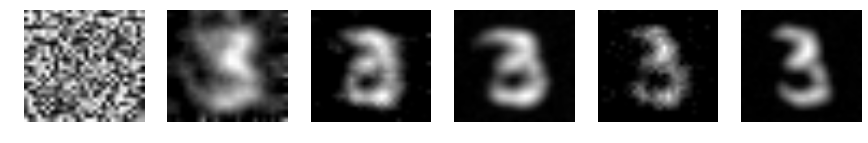

In [20]:
# Plotting sampled numbers
n = 0

fig = plt.figure(figsize=(15,2))

fig.add_subplot(1,n_iter+1,1)
x_show = X_train_rng[n] * 255
imshow(x_show.reshape((28,28)), cmap=cm.gray, aspect='auto')
plt.axis('off')

for k in range(n_iter):
    fig.add_subplot(1,n_iter+1,k + 2)

    x_show = x_conv[k][n] * 255.
    imshow(x_show.reshape((28,28)), cmap=cm.gray, aspect='auto')
    plt.axis('off')

fig.show()

plt.autoscale(False)

Intuitivelly, on intial steps the gradient of the score distribution given the score  $\frac{d p(s(x))}{d s}$ have just a little information on how to transform the random noise into a MNIST number, this is because the neural network do a great work indentifying between noise and a MNIST number, then most of the values of the distribution are concentrated on the edges giving no clue about its gradients. As the iteration continues the task of identifying between MNIST numbers and the sampled results become harder and there is more information in the derivative in order to make the transformation. 

This are initial results, some things to solve are:
- As mentioned before, the gradients of the probability distribution are problematic in the initial steps since the approximated distribution is peaky. I think that this can be solved by using a monotonic transformation of the score which allow more smooth distributions or using better approximation methods (maybe GP?).
- Right now the method is not working for multimodal distributions (all the MNIST numbers). I need to understand why this is happening.
- The iterative method can be understood as a deep model where each iteration is training a different layer of the deep model. Then the final model is the stacked version of all the models trained in each iteration where each layer is making a better estimation using the output of the previous layer (just like a DBN). This can be used as an unsupervised pretraining strategy. Experiments need to be made on this.